In [ ]:
import pandas as pd

df = pd.read_excel('data.xlsx')
df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


Проводим классификацию для признака IC50, который характеризует эффективность молекулы. Цель классификации - определить, превышает ли IC50 медианное значение в выборке. Такая классификация помогает быстро отсеивать менее эффективные соединения, ускоряя процесс разработки новых лекарственных препаратов.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Переименуем столбцы
df.rename(columns={'IC50, mM': 'IC50', 'CC50, mM': 'CC50'}, inplace=True)

# IC50 > медиана бинарная
median_ic50 = df['IC50'].median()
df['IC50_above_median'] = (df['IC50'] > median_ic50).astype(int)

# Признаки
X = df.drop(columns=['IC50', 'CC50', 'SI', 'Unnamed: 0', 'IC50_above_median'])

# Целевая переменная
y = df['IC50_above_median']

# Импутация
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)


In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1]
}

grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                        param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

print("Лучшие параметры XGBoost:", grid_xgb.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
models = {
    'Logistic Regression': y_pred_logreg,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'XGBoost (Best)': y_pred_best_xgb
}

for name, y_pred in models.items():
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"{name}:\n  Accuracy = {acc:.4f}\n  F1-score = {f1:.4f}\n  ROC-AUC = {auc:.4f}\n")


Logistic Regression:
  Accuracy = 0.6866
  F1-score = 0.7070
  ROC-AUC = 0.6869

Random Forest:
  Accuracy = 0.6965
  F1-score = 0.7189
  ROC-AUC = 0.6969

XGBoost:
  Accuracy = 0.7065
  F1-score = 0.7230
  ROC-AUC = 0.7068

XGBoost (Best):
  Accuracy = 0.7264
  F1-score = 0.7465
  ROC-AUC = 0.7268



Я провела задачу бинарной классификации для признака IC50 (выше медианы или нет), сравнив несколько моделей: Logistic Regression, Random Forest и XGBoost. Все модели показали сопоставимые результаты, но после настройки гиперпараметров XGBoost (Best) стал работать лучше всех.

Лучшие результаты показал XGBoost (Best):

Accuracy —-0.7264, что означает, что модель правильно классифицировала примерно 73% всех примеров.
F1-score - 0.7465, что говорит о хорошем балансе между точностью и полнотой — модель не только верно предсказывает положительный класс, но и не сильно ошибается с отрицательным.
ROC-AUC - 0.7268, что демонстрирует достойное разделение классов.
Таким образом, настройка гиперпараметров действительно помогла модели XGBoost работать лучше, чем Logistic Regression и Random Forest.

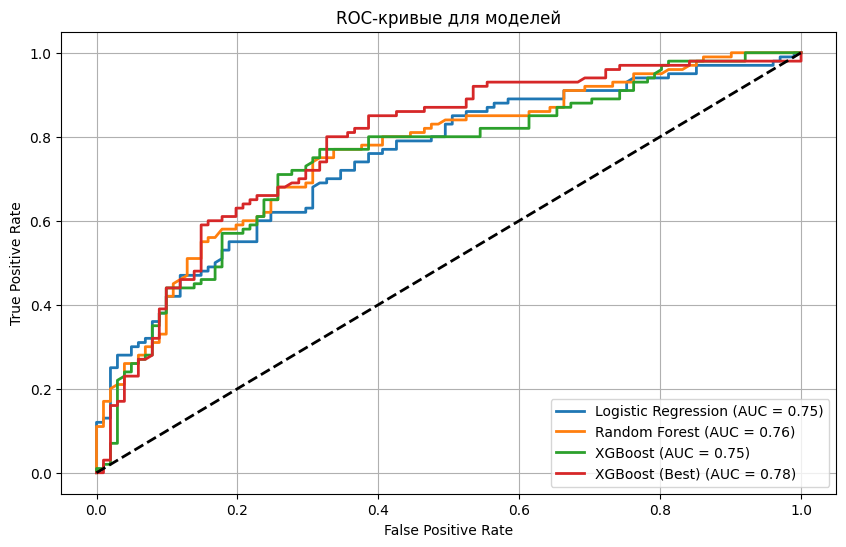

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

models_proba = {
    'Logistic Regression': logreg.predict_proba(X_test)[:, 1],
    'Random Forest': rf.predict_proba(X_test)[:, 1],
    'XGBoost': xgb.predict_proba(X_test)[:, 1],
    'XGBoost (Best)': best_xgb.predict_proba(X_test)[:, 1]
}

plt.figure(figsize=(10, 6))
for name, y_proba in models_proba.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для моделей')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


AUC (Area Under Curve) показывает общую способность модели различать классы (чем выше, тем лучше). В нашем случае все модели показали хорошие результаты (AUC около 0.75–0.78), что говорит о том, что они умеют достаточно уверенно различать «эффективные» и «неэффективные» соединения.

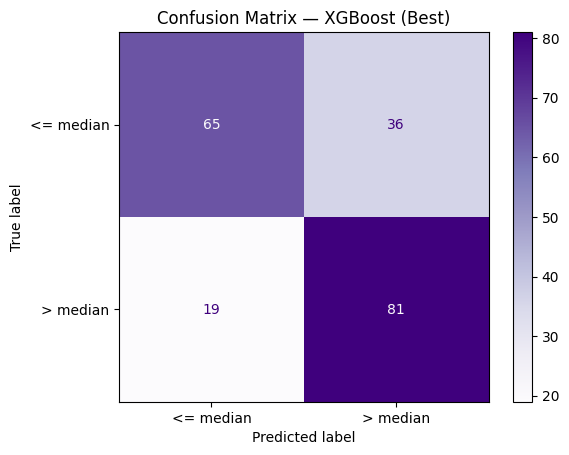

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, display_labels=['<= median', '> median'], cmap='Purples', colorbar=True)
plt.title('Confusion Matrix — XGBoost (Best)')
plt.grid(False)
plt.show()


Модель достаточно хорошо справляется с задачей, правильно определяя большинство объектов в обеих классах (65 и 81). Однако есть некоторое количество ошибок (36 False Positive и 19 False Negative). В данном контексте такие ошибки означают, что модель иногда ошибается в прогнозах, определяя молекулы как более или менее эффективные, чем они есть на самом деле. Тем не менее, при общем балансе классов результаты модели XGBoost (Best) можно оценить как хорошие.

Распределение классов:
IC50_above_median
0    501
1    500
Name: count, dtype: int64


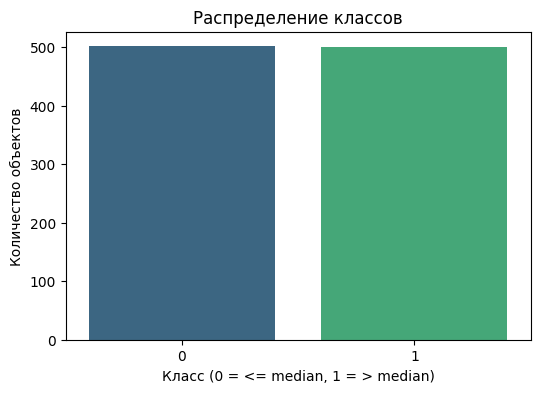

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['IC50_above_median'].value_counts()
print("Распределение классов:")
print(class_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Класс (0 = <= median, 1 = > median)')
plt.ylabel('Количество объектов')
plt.title('Распределение классов')
plt.show()


Нет диссбаланса

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17943
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 170
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

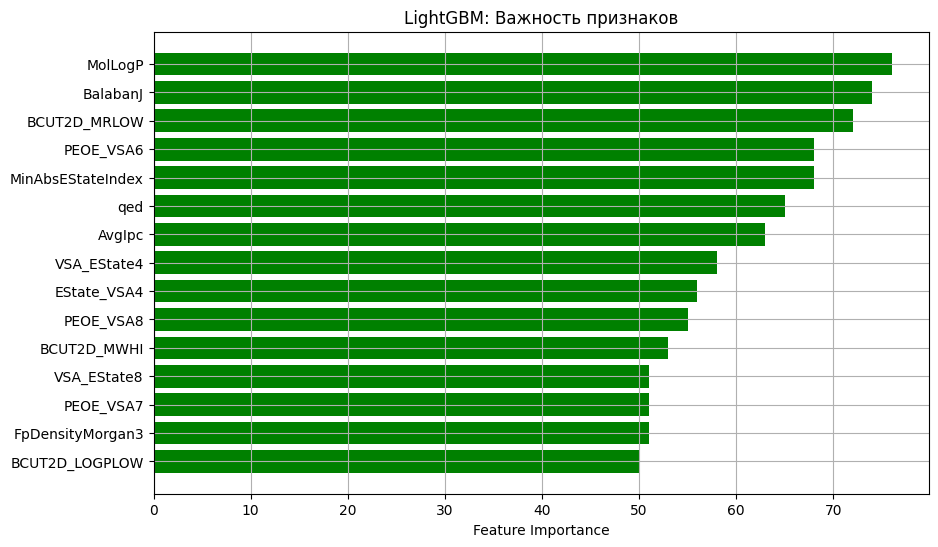

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# LightGBM
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)

# Предсказания
y_pred_lgb = lgb_clf.predict(X_test)
y_proba_lgb = lgb_clf.predict_proba(X_test)[:, 1]

# Метрики
acc_lgb = accuracy_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)
auc_lgb = roc_auc_score(y_test, y_proba_lgb)

print(f"LightGBM:\n  Accuracy = {acc_lgb:.4f}\n  F1-score = {f1_lgb:.4f}\n  ROC-AUC = {auc_lgb:.4f}")

# Важность признаков
importances = lgb_clf.feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[indices], importances[indices], color='green')
plt.xlabel('Feature Importance')
plt.title('LightGBM: Важность признаков')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


LightGBM показал хорошие результаты, особенно по ROC-AUC, который указывает на хорошую способность различать классы. При этом accuracy и F1-score у LightGBM примерно такие же, как у Random Forest и XGBoost.

In [ ]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('xgb', best_xgb),
    ('rf', rf),
    ('logreg', logreg)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

acc_stack = accuracy_score(y_test, y_pred_stack)
f1_stack = f1_score(y_test, y_pred_stack)
auc_stack = roc_auc_score(y_test, y_proba_stack)

print(f"Stacking Classifier:\n  Accuracy = {acc_stack:.4f}\n  F1-score = {f1_stack:.4f}\n  ROC-AUC = {auc_stack:.4f}")


Stacking Classifier:
  Accuracy = 0.6965
  F1-score = 0.7215
  ROC-AUC = 0.7831


Стекинг объединяет лучшие решения базовых моделей (Random Forest, XGBoost, Logistic Regression) и позволяет использовать их сильные стороны. Результаты показывают, что ансамбль моделей способен лучше различать классы и обеспечивает наилучший ROC-AUC.

MoLogP - это логарифм коэффициента распределения (водорастворимость/жирорастворимость). Это ключевой параметр, который показывает, насколько молекула может проникать через мембраны и взаимодействовать с биологическими объектами. Чем выше этот показатель, тем более «жирорастворимой» (липофильной) является молекула. В нашем случае это влияет на активность и эффективность соединений.
BalabanJ - это топологический индекс, связанный с общей «сложностью» и «ветвистостью» молекулы. Высокое значение BalabanJ может говорить о том, что у молекулы более сложная структура, что влияет на её активность против вируса.
BCUT2D_MRLOW - это дескриптор, связанный с поляризуемостью и молекулярной массой. Он отражает, как молекула может взаимодействовать с другими молекулами, что тоже важно для активности.
Остальные признаки (PEOE_VSA6, MinAbsEStateIndex, qed, AvgIpc и др.) тоже важны, но их влияние меньше. В целом, мы видим, что структура молекулы (её размер, форма, распределение зарядов) играет очень важную роль в предсказании эффективности против вируса.

